# Convolutional Neural Networks: Classification model
## Vesna Pop-Dimitrijoska
---



## Task
Experimenting with a couple of different Convolutional Neural Network architectures for binary classification of cats and dogs. Database contains 37500 pictures of cats and dogs. 

---
## Loading the libraries

In [1]:
import numpy as np
import random
import glob
import pathlib
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import cv2

IMG_SIZE = (80, 100)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Read the dataset

In [2]:
train_files = glob.glob('train/*.*')
test_files = glob.glob('test/*.*')
print(len(train_files))
print(len(test_files))

25000
12500


In [3]:
def readDataset(files):
    dataset = np.zeros((len(files), IMG_SIZE[0], IMG_SIZE[1], 3)) 
    for i, fpath in enumerate(files):
        image = cv2.imread(fpath, cv2.COLOR_BGR2RGB).astype(np.float32)  #cv2.IMREAD_UNCHANGED
        image = cv2.resize(image, (IMG_SIZE[1], IMG_SIZE[0]))
        image /= 255.0
        dataset[i] = image
    return dataset

In [4]:
X_tv = readDataset(train_files)
X_test = readDataset(test_files)

In [5]:
print(X_tv.shape)
print(X_test.shape)

(25000, 80, 100, 3)
(12500, 80, 100, 3)


In [6]:
Y_tv = np.array([1 if pathlib.Path(el).name.split('.')[0]=='dog' else 0  for el in train_files])
Y_tv.shape

(25000,)

In [7]:
classes = ['Cat', 'Dog']

## Train - Validation - Test split

In [8]:
X_train, X_vt, Y_train, Y_vt = train_test_split(X_tv, Y_tv, test_size=0.3, shuffle=True, random_state=SEED, stratify = Y_tv)
X_val, X_test1, Y_val, Y_test1 = train_test_split(X_vt, Y_vt, test_size=0.5, shuffle=True, random_state=SEED, stratify = Y_vt)

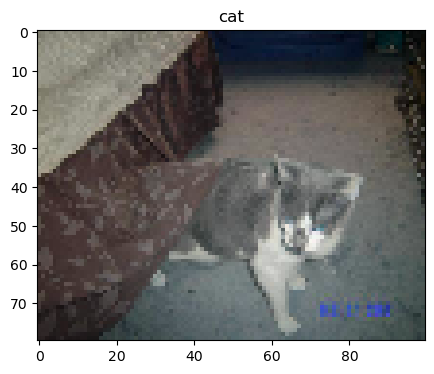

In [9]:
idx = 15
fig = plt.figure(figsize=(5,5))
plt.imshow(X_train[idx])
plt.title('cat' if Y_train[idx]==0 else 'dog')
plt.show()

In [10]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test1:", X_test1.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_val:", Y_val.shape)

X_train: (17500, 80, 100, 3)
X_val: (3750, 80, 100, 3)
X_test1: (3750, 80, 100, 3)
X_test: (12500, 80, 100, 3)
Y_train: (17500,)
Y_val: (3750,)


In [11]:
print(Counter(Y_train))
print(Counter(Y_val))
print(Counter(Y_test1))

Counter({1: 8750, 0: 8750})
Counter({1: 1875, 0: 1875})
Counter({1: 1875, 0: 1875})


---
# Convolutional Neural Networks: Classification model

## Model definition and optimization process

In [12]:
model = Sequential()

model.add(Input((*IMG_SIZE, 3)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(Dropout(0.1)) 
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 76, 96, 16)        1216      
                                                                 
 dropout (Dropout)           (None, 76, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 92, 32)        12832     
                                                                 
 dropout_1 (Dropout)         (None, 72, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 44, 64)        18496     
                                                        

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

## Data augmentation
- Translation relative to x axis
- Translation relative to y axis
- Horizontal Flip

In [14]:
datagen = ImageDataGenerator(
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip = True, 
)
datagen.fit(X_train)
datagen

## Training the model

In [15]:
es_cbk = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model_history = model.fit(datagen.flow(X_train, Y_train, batch_size=64),
                            epochs=300,
                            validation_data=(X_val, Y_val),
                            callbacks=[es_cbk]
)

Epoch 1/300
274/274 [==============================] - 222s 791ms/step - loss: 0.6895 - accuracy: 0.5273 - val_loss: 0.6687 - val_accuracy: 0.6269
Epoch 2/300
274/274 [==============================] - 209s 755ms/step - loss: 0.6214 - accuracy: 0.6627 - val_loss: 0.5861 - val_accuracy: 0.6947
Epoch 3/300
274/274 [==============================] - 198s 716ms/step - loss: 0.5573 - accuracy: 0.7188 - val_loss: 0.5469 - val_accuracy: 0.7235
Epoch 4/300
274/274 [==============================] - 208s 753ms/step - loss: 0.5307 - accuracy: 0.7392 - val_loss: 0.4986 - val_accuracy: 0.7781
Epoch 5/300
274/274 [==============================] - 201s 726ms/step - loss: 0.5077 - accuracy: 0.7561 - val_loss: 0.4834 - val_accuracy: 0.7683
Epoch 6/300
274/274 [==============================] - 197s 712ms/step - loss: 0.4759 - accuracy: 0.7754 - val_loss: 0.4302 - val_accuracy: 0.8064
Epoch 7/300
274/274 [==============================] - 200s 723ms/step - loss: 0.4631 - accuracy: 0.7852 - val_loss: 0

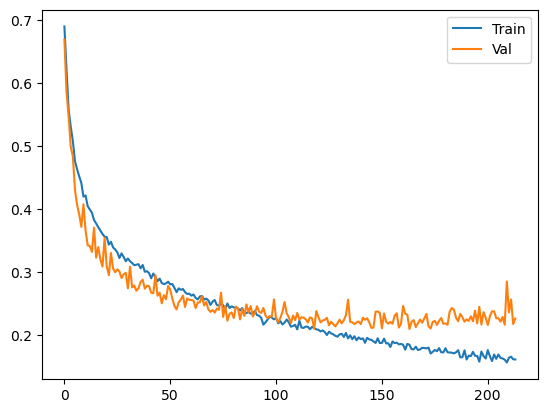

In [16]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['Train', "Val"])

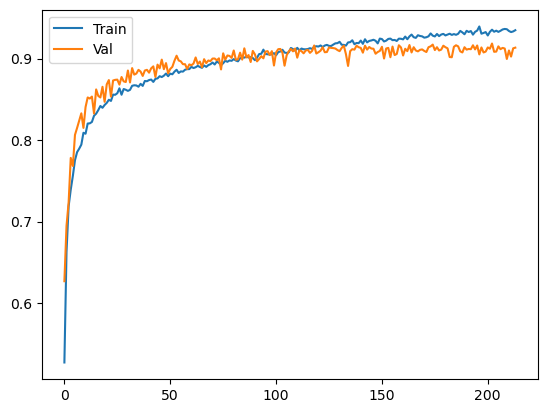

In [17]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['Train', "Val"])

## Model prediction and evaluation

In [18]:
Y_pred_probability = model.predict(X_test1) 
Y_pred = (Y_pred_probability >= 0.5).astype(int)

print('F1 score (macro):', round((f1_score(Y_test1, Y_pred, average='macro'))*100, 2), '%')
print('Accuracy        :', round((accuracy_score(Y_test1, Y_pred))*100, 2), '%')
print('Precision score :', round((precision_score(Y_test1, Y_pred))*100, 2), '%')
print('Recall score    :', round((recall_score(Y_test1, Y_pred))*100, 2), '%')
print('\nConfusion Matrix:\n', confusion_matrix(Y_test1, Y_pred))
print('\nClassification Report:\n', classification_report(Y_test1, Y_pred))

118/118 [==============================] - 32s 141ms/step
F1 score (macro): 90.16 %
Accuracy        : 90.16 %
Precision score : 90.44 %
Recall score    : 89.81 %

Confusion Matrix:
 [[1697  178]
 [ 191 1684]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1875
           1       0.90      0.90      0.90      1875

    accuracy                           0.90      3750
   macro avg       0.90      0.90      0.90      3750
weighted avg       0.90      0.90      0.90      3750



In [62]:
np.random.shuffle(X_test)
y_pred = model.predict(X_test[0:25]).round(0)

1/1 [==============================] - 1s 1s/step


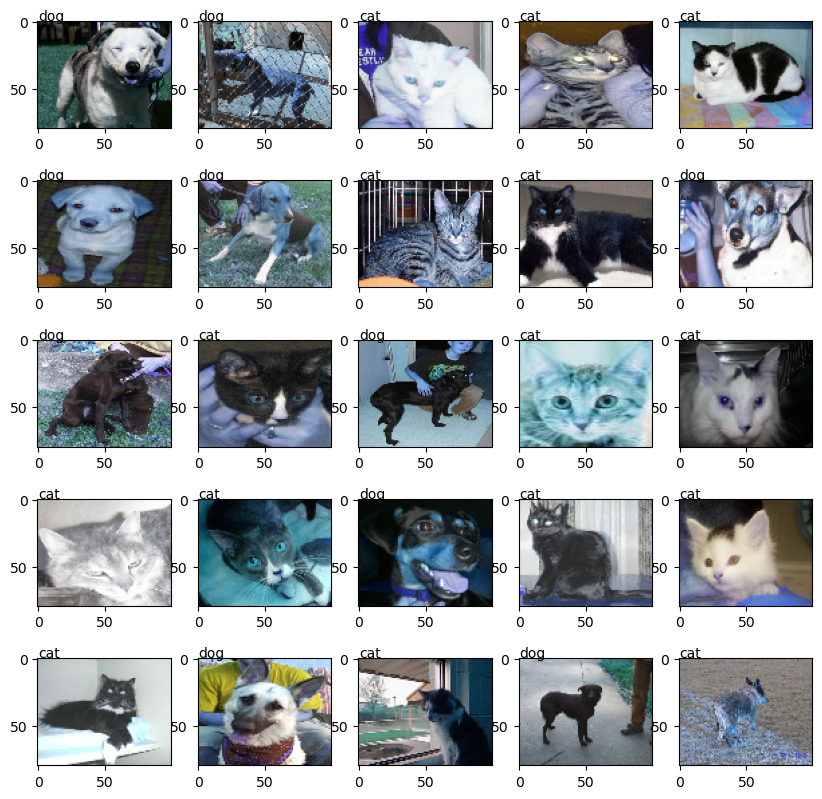

In [63]:
fig = plt.figure(figsize=(10,10))
for i in range(5*5):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(X_test[i])
    title = 'dog' if y_pred[i] == 1 else 'cat'
    ax.text(0, -1, title, size=10)

## Saving the model

In [60]:
model.save(pathlib.Path("models", 'best_model'))

INFO:tensorflow:Assets written to: models\best_model\assets


INFO:tensorflow:Assets written to: models\best_model\assets


In [61]:
import pathlib
from keras.models import load_model

best_model_path = pathlib.Path('models', 'best_model')
read_model = load_model(best_model_path)

## Results

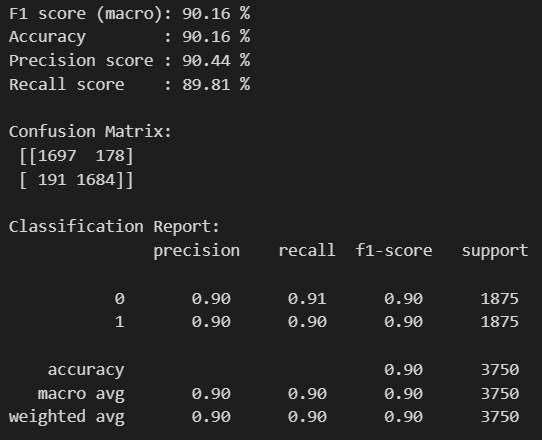

---

## Conclusion

The model was significanlty improved by using Data augmentation technique which is increasing the amount of data available for training by generating new training examples from existing ones and applying some transformations.

I tested multiple architectures and one of the best performance was achived with the model shown here.

Тhanks to the Train-Validation-Test split, I was able to evaluate the model, because our test data was without notation. 

By picking 25 random images from the test set, it can be observed that 24 of them were accurately predicted.

---